### Student Information
Name:陳玠霖

Student ID:111065553

GitHub ID:TwPanTsu

Kaggle name:PanTsuEzPz

Kaggle private scoreboard snapshot:

[Snapshot](img/pic0.png)

---

### Instructions

1. First: __This part is worth 30% of your grade.__ Do the **take home** exercises in the [DM2022-Lab2-master Repo](https://github.com/keziatamus/DM2022-Lab2-Master). You may need to copy some cells from the Lab notebook to this notebook. 


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/competitions/dm2022-isa5810-lab2-homework) regarding Emotion Recognition on Twitter by this link https://www.kaggle.com/t/2b0d14a829f340bc88d2660dc602d4bd. The scoring will be given according to your place in the Private Leaderboard ranking: 
    - **Bottom 40%**: Get 20% of the 30% available for this section.

    - **Top 41% - 100%**: Get (60-x)/6 + 20 points, where x is your ranking in the leaderboard (ie. If you rank 3rd your score will be (60-3)/6 + 20 = 29.5% out of 30%)   
    Submit your last submission __BEFORE the deadline (Nov. 22th 11:59 pm, Tuesday)_. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developping the model for the competition (You can use code and comment it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained. 


4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook** and **add minimal comments where needed**.


Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Nov. 25th 11:59 pm, Friday)__. 

### 1. First: __This part is worth 30% of your grade.
[Click Me! My Own DM2022-Lab2-master](https://github.com/TwPanTsu/DM2022-Lab2-Master.git).
### the rest of the homework will be here! 

In [1]:
### Begin Assignment Here
### import needed
###if encounter keras and tensorflow missing, install them thru anaconda
import pandas as pd
import json
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
import keras
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import ReLU, Softmax
from keras.callbacks import CSVLogger

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\datalab\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 1.1 Load data

In [2]:
###read file from the folder 'data'
data_identification = pd.read_csv('data/data_identification.csv')
emotion = pd.read_csv('data/emotion.csv')
sampleSubmission = pd.read_csv('data/sampleSubmission.csv')
print(data_identification[0:5])
print(emotion[0:5])
print(sampleSubmission[0:5])

   tweet_id identification
0  0x28cc61           test
1  0x29e452          train
2  0x2b3819          train
3  0x2db41f           test
4  0x2a2acc          train
   tweet_id       emotion
0  0x3140b1       sadness
1  0x368b73       disgust
2  0x296183  anticipation
3  0x2bd6e1           joy
4  0x2ee1dd  anticipation
         id   emotion
0  0x2c7743  surprise
1  0x2c1eed  surprise
2  0x2826ea  surprise
3  0x356d9a  surprise
4  0x20fd95  surprise


In [3]:
#loads data (a lots of time)
#CAUTION!!!
tweets = []
for line in open('data/tweets_DM.json', 'r'):
    tweets.append(json.loads(line))

In [4]:
#tweets example
tweets[0]

{'_score': 391,
 '_index': 'hashtag_tweets',
 '_source': {'tweet': {'hashtags': ['Snapchat'],
   'tweet_id': '0x376b20',
   'text': 'People who post "add me on #Snapchat" must be dehydrated. Cuz man.... that\'s <LH>'}},
 '_crawldate': '2015-05-23 11:42:47',
 '_type': 'tweets'}

In [5]:
#find identity:train or test?
findiden={}
for i in range(len(data_identification)):
    findiden[data_identification['tweet_id'][i]] = data_identification['identification'][i]
#example
findiden['0x28cc61']

'test'

In [6]:
#find emotion : 8 type from train data
findemo={}
for i in range(len(emotion)):
    findemo[emotion['tweet_id'][i]] = emotion['emotion'][i]
#example
findemo['0x3140b1']

'sadness'

In [7]:
#find sam: 8 type from test data
findsam={}
for i in range(len(sampleSubmission)):
    findsam[sampleSubmission['id'][i]] = sampleSubmission['emotion'][i]
#example
findsam['0x2c7743']

'surprise'

In [8]:
#create full dataframe for test and train
fullid_test=[]
fullid_train=[]
fulltext_test=[]
fulltext_train=[]
fullemo_test=[]
fullemo_train=[]

for i in range (len(tweets)):
    if (findiden[tweets[i]['_source']['tweet']['tweet_id']] == 'test'):
        fullid_test.append(tweets[i]['_source']['tweet']['tweet_id'])
        fulltext_test.append(tweets[i]['_source']['tweet']['text'])
        fullemo_test.append(findsam[tweets[i]['_source']['tweet']['tweet_id']])
    elif(findiden[tweets[i]['_source']['tweet']['tweet_id']] == 'train'):
        fullid_train.append(tweets[i]['_source']['tweet']['tweet_id'])
        fulltext_train.append(tweets[i]['_source']['tweet']['text'])
        fullemo_train.append(findemo[tweets[i]['_source']['tweet']['tweet_id']])
Ser1_test = pd.Series(fullid_test)
Ser2_test = pd.Series(fulltext_test)
Ser3_test = pd.Series(fullemo_test)
Ser1_train = pd.Series(fullid_train)
Ser2_train = pd.Series(fulltext_train)
Ser3_train = pd.Series(fullemo_train)
df_test = pd.DataFrame({'id':Ser1_test, 'text':Ser2_test, 'emotion':Ser3_test})
df_train = pd.DataFrame({'id':Ser1_train, 'text':Ser2_train, 'emotion':Ser3_train})

In [9]:
df_train[0:5]
#inside train set

,id,text,emotion
0,0x376b20,"People who post ""add me on #Snapchat"" must be ...",anticipation
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #...",sadness
2,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,fear
3,0x1d755c,@RISKshow @TheKevinAllison Thx for the BEST TI...,joy
4,0x2c91a8,Still waiting on those supplies Liscus. <LH>,anticipation


In [10]:
df_test[0:5]
#inside test set
#we need to predict test set and we don't know the answer.
#so i borrow samplesubmition to use.(all answers are 'surprise')

,id,text,emotion
0,0x28b412,"Confident of your obedience, I write to you, k...",surprise
1,0x2de201,"""Trust is not the same as faith. A friend is s...",surprise
2,0x218443,When do you have enough ? When are you satisfi...,surprise
3,0x2939d5,"God woke you up, now chase the day #GodsPlan #...",surprise
4,0x26289a,"In these tough times, who do YOU turn to as yo...",surprise


In [11]:
# shuffle dataset
df_train = df_train.sample(frac=1)
df_test = df_test.sample(frac=1)
print("Shape of Training df: ", df_train.shape)
print("Shape of Testing df: ", df_test.shape)

Shape of Training df:  (1455563, 3)
Shape of Testing df:  (411972, 3)


In [12]:
df_train[0:5]

,id,text,emotion
1006479,0x2e22ae,Moving on up in my career!🔑 <LH>,trust
425458,0x2cf55a,@DanHowells5 @cardiffdevils Enjoy! Wear it wit...,trust
950156,0x26a270,I don't like to be normal. <LH> <LH> <LH>,sadness
634568,0x29d1d8,When you get sick a week before vacation and s...,sadness
1100588,0x2044ba,Affirmation: Today I turn my frequency to <LH>...,anticipation


In [13]:
df_test[0:5]

,id,text,emotion
115595,0x20681a,Despite our best intentions... we have a God t...,surprise
146233,0x3893d7,there's a small child singing gloria at the ho...,surprise
59654,0x355d46,Wow fell asleep on the couch at 9:30pm. Woke u...,surprise
77323,0x37f3a2,Just got today and I've got 7 days off! Anothe...,surprise
344854,0x2c8113,.@Vichy_USA just bought your 3 in 1 & night cr...,surprise


In [14]:
##top 100 feature to see what features inside
count_vectorizer = CountVectorizer(max_features=100)
df_train_counts = count_vectorizer.fit_transform(df_train.text)
term_frequencies_train = np.asarray(df_train_counts.sum(axis=0))
train_feature_names = count_vectorizer.get_feature_names_out()
df_test_counts = count_vectorizer.fit_transform(df_test.text)
term_frequencies_test = np.asarray(df_test_counts.sum(axis=0))
test_feature_names = count_vectorizer.get_feature_names_out()

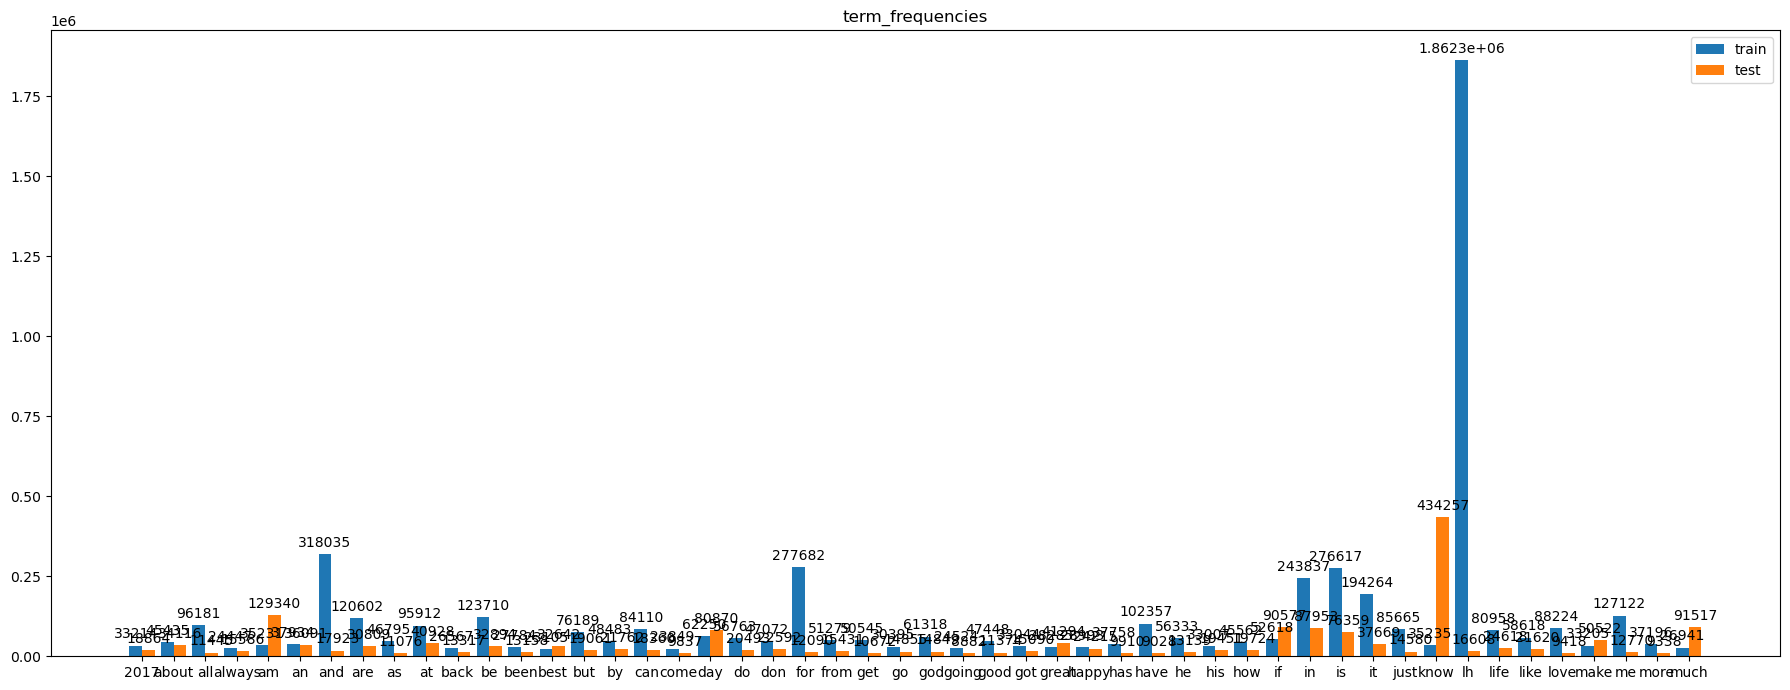

In [15]:
##graph 1 [0:50]
x = np.arange(50)  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(18,7))
rects1 = ax.bar(x - width/2, term_frequencies_train[0][0:50], width, label='train')
rects2 = ax.bar(x + width/2, term_frequencies_test[0][0:50], width, label='test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('term_frequencies')
ax.set_xticks(x, train_feature_names[0:50])
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()
plt.show()

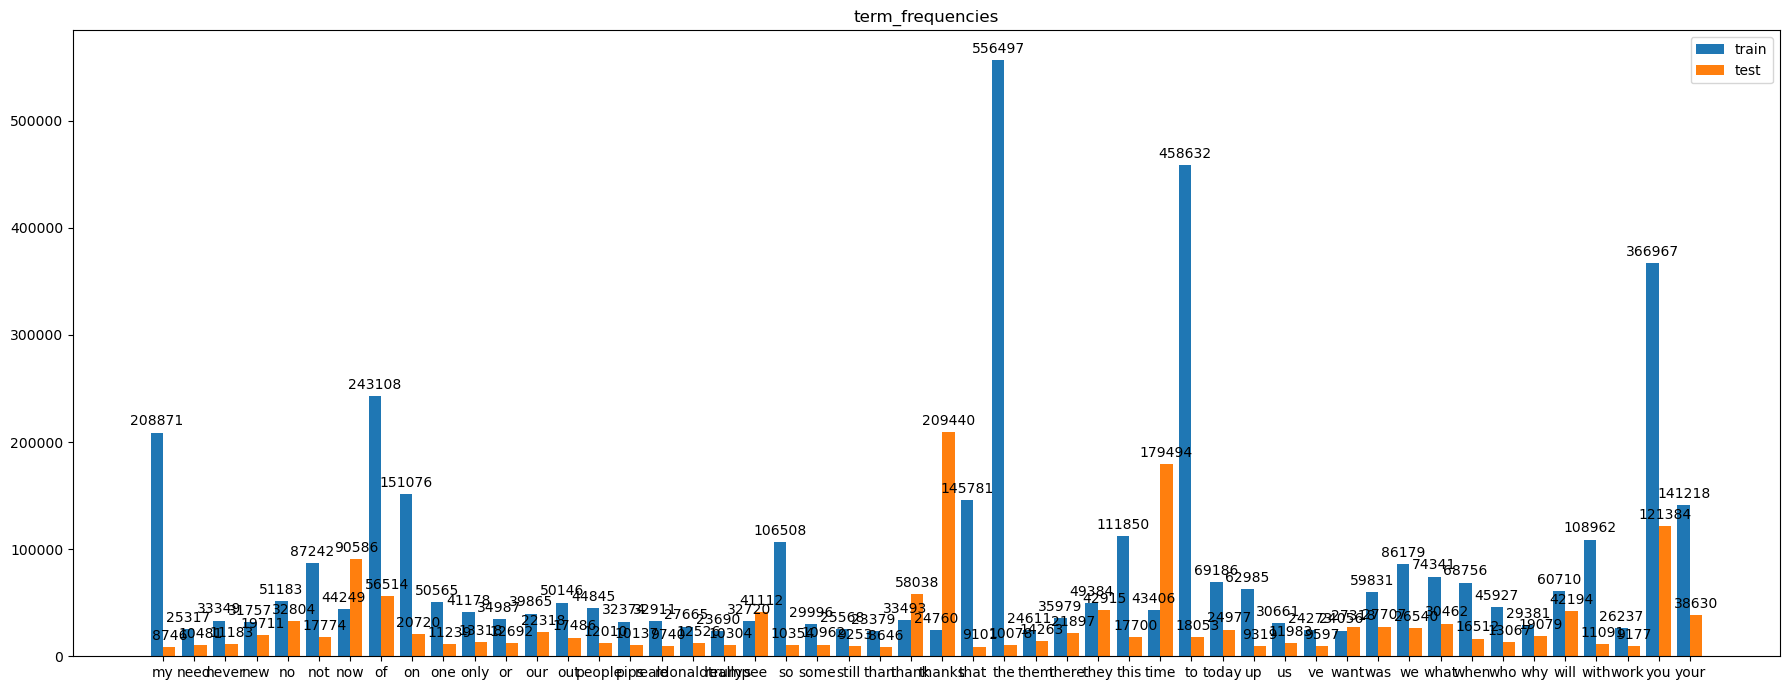

In [16]:
##graph 2 [50:100]
x = np.arange(50)  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(18,7))
rects1 = ax.bar(x - width/2, term_frequencies_train[0][50:100], width, label='train')
rects2 = ax.bar(x + width/2, term_frequencies_test[0][50:100], width, label='test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('term_frequencies')
ax.set_xticks(x, train_feature_names[50:100])
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()
plt.show()

### 1.2 Save data

In [17]:
## save to csv
df_train.to_csv('train_data.csv', index=False) 
df_test.to_csv('test_data.csv', index=False) 
## save to pickle file
df_train.to_pickle("df_train.pkl") 
df_test.to_pickle("df_test.pkl")
## load a pickle file
df_train = pd.read_pickle("df_train.pkl")
df_test = pd.read_pickle("df_test.pkl")

### 1.3 Exploratory data analysis (EDA)

In [18]:
# group to find distribution
df_train.groupby(['emotion']).count()['text']

emotion
anger            39867
anticipation    248935
disgust         139101
fear             63999
joy             516017
sadness         193437
surprise         48729
trust           205478
Name: text, dtype: int64

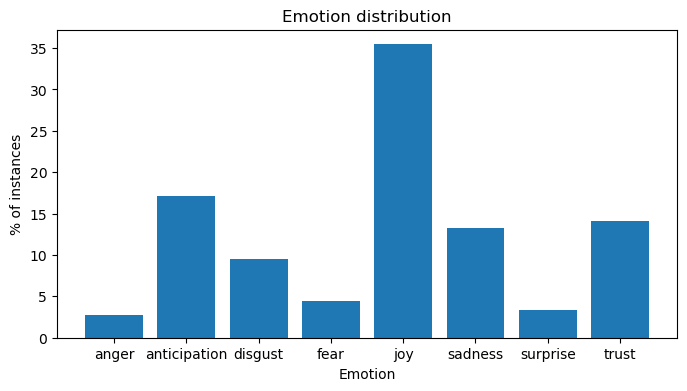

In [19]:
# the histogram of the train data
labels = df_train['emotion'].unique()
post_total = len(df_train)
df1 = df_train.groupby(['emotion']).count()['text']
df1 = df1.apply(lambda x: round(x*100/post_total,3))

#plot
fig, ax = plt.subplots(figsize=(8,4))
plt.bar(df1.index,df1.values)

#arrange
plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.title('Emotion distribution')
plt.show()

In [20]:
##I think its unfair to having one data that have 35%
##so i want to try having a uniform disturbution
emo_type=['anger', 'anticipation', 'disgust', 'fear', 'sadness', 'surprise', 'trust', 'joy']
fliter = (df_train["emotion"] == "anger")
df_train_anger = df_train[fliter]
fliter = (df_train["emotion"] == "anticipation")
df_train_anticipation = df_train[fliter]
fliter = (df_train["emotion"] == "disgust")
df_train_disgust = df_train[fliter]
fliter = (df_train["emotion"] == "fear")
df_train_fear = df_train[fliter]
fliter = (df_train["emotion"] == "sadness")
df_train_sadness = df_train[fliter]
fliter = (df_train["emotion"] == "surprise")
df_train_surprise = df_train[fliter]
fliter = (df_train["emotion"] == "trust")
df_train_trust = df_train[fliter]
fliter = (df_train["emotion"] == "joy")
df_train_joy = df_train[fliter]
print(len(df_train_anger))
print(len(df_train_anticipation))
print(len(df_train_disgust))
print(len(df_train_fear))
print(len(df_train_sadness))
print(len(df_train_surprise))
print(len(df_train_trust))
print(len(df_train_joy))

39867
248935
139101
63999
193437
48729
205478
516017


In [21]:
##anger has smallest data(39867) so others should be too.
df_train_anger = df_train_anger[0:39867]
df_train_anticipation = df_train_anticipation[0:39867]
df_train_disgust = df_train_disgust[0:39867]
df_train_fear = df_train_fear[0:39867]
df_train_sadness = df_train_sadness[0:39867]
df_train_surprise = df_train_surprise[0:39867]
df_train_trust = df_train_trust[0:39867]
df_train_joy = df_train_joy[0:39867]
df_train_uni=pd.concat([df_train_anger, df_train_anticipation, df_train_disgust, df_train_fear, df_train_sadness, df_train_surprise, df_train_trust, df_train_joy ],axis=0)
print(len(df_train_uni))

318936


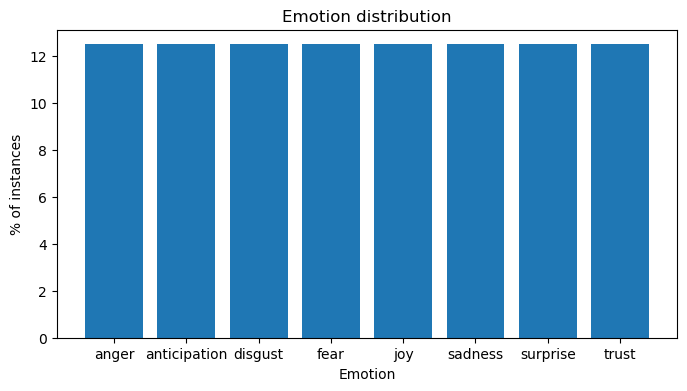

In [22]:
# the histogram of the train data(uni version)
labels = df_train_uni['emotion'].unique()
post_total = len(df_train_uni)
df1 = df_train_uni.groupby(['emotion']).count()['text']
df1 = df1.apply(lambda x: round(x*100/post_total,3))

#plot
fig, ax = plt.subplots(figsize=(8,4))
plt.bar(df1.index,df1.values)

#arrange
plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.title('Emotion distribution')
plt.show()

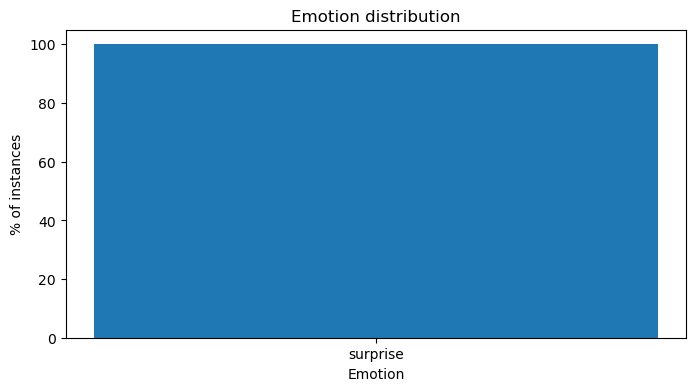

In [23]:
# the histogram of the test data(all are 'surprise' because we don't know the answer)
labels = df_test['emotion'].unique()
post_total = len(df_test)
df1 = df_test.groupby(['emotion']).count()['text']
df1 = df1.apply(lambda x: round(x*100/post_total,3))

#plot
fig, ax = plt.subplots(figsize=(8,4))
plt.bar(df1.index,df1.values)

#arrange
plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.title('Emotion distribution')
plt.show()

### 2. Feature engineering

In [92]:
# build analyzers (bag-of-words)
# tried 100 200 300 400 500 600
BOW = CountVectorizer(max_features=400, tokenizer=nltk.word_tokenize) 

# apply analyzer to training data
BOW.fit(df_train['text'])

BOW_train = BOW.transform(df_train['text'])
BOW_test = BOW.transform(df_test['text'])
## check dimension
BOW_train.shape

C:\Users\datalab\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(1455563, 400)

In [93]:
BOW_train.toarray()

array([[1, 0, 0, ..., 0, 0, 0],
       [2, 2, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 4, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 3, 0, ..., 0, 0, 0]], dtype=int64)

In [94]:
# observe some feature names
feature_names = BOW.get_feature_names_out()
feature_names[0:10]

array(['!', '#', '$', '%', '&', "'", "''", "'d", "'ll", "'m"],
      dtype=object)

In [95]:
"😂" in feature_names

True

## Deep Learning

In [96]:
# standardize name (X, y) 
X_train = BOW_train
y_train = df_train['emotion']

X_test = BOW_test
y_test = df_test['emotion']

## check dimension is a good habbit 
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (1455563, 400)
y_train.shape:  (1455563,)
X_test.shape:  (411972, 400)
y_test.shape:  (411972,)


In [97]:
## deal with label (string -> one-hot)
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
print('check label: ', label_encoder.classes_)
print('\n## Before convert')
print('y_train[0:8]:\n', y_train[0:8])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)

check label:  ['anger' 'anticipation' 'disgust' 'fear' 'joy' 'sadness' 'surprise'
 'trust']

## Before convert
y_train[0:8]:
 1006479           trust
425458            trust
950156          sadness
634568          sadness
1100588    anticipation
150177          sadness
1340667             joy
98384             trust
Name: emotion, dtype: object

y_train.shape:  (1455563,)
y_test.shape:  (411972,)


In [98]:
def label_encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

y_train = label_encode(label_encoder, y_train)
y_test = label_encode(label_encoder, y_test)

print('\n\n## After convert')
print('y_train[0:5]:\n', y_train[0:5])
print('y_test[0:5]:\n', y_test[0:5])
print('fixing y_text')
eighth = np.zeros((len(y_test),1))
y_test = np.append(y_test, eighth, axis = 1)
print('y_test[0:5]:\n', y_test[0:5])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)



## After convert
y_train[0:5]:
 [[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]]
y_test[0:5]:
 [[0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]]
fixing y_text
y_test[0:5]:
 [[0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]]

y_train.shape:  (1455563, 8)
y_test.shape:  (411972, 8)


In [99]:
# I/O check
input_shape = X_train.shape[1]
print('input_shape: ', input_shape)

output_shape = len(label_encoder.classes_)
print('output_shape: ', output_shape)

input_shape:  400
output_shape:  8


In [100]:
# input layer
model_input = Input(shape=(input_shape, ))  # 500
X = model_input

# 1st hidden layer
X_W1 = Dense(units=256)(X)  # 256
H1 = ReLU()(X_W1)

# 2nd hidden layer
H1_W2 = Dense(units=128)(H1)  # 128
H2 = ReLU()(H1_W2)

# 3nd hidden layer
H2_W3 = Dense(units=64)(H2)  # 64
H3 = ReLU()(H2_W3)

# output layer
H3_W4 = Dense(units=output_shape)(H3)  # 4
H4 = Softmax()(H3_W4)

model_output = H4

# create model
model = Model(inputs=[model_input], outputs=[model_output])

# loss function & optimizer
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# show model construction
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 400)]             0         
                                                                 
 dense_16 (Dense)            (None, 256)               102656    
                                                                 
 re_lu_12 (ReLU)             (None, 256)               0         
                                                                 
 dense_17 (Dense)            (None, 128)               32896     
                                                                 
 re_lu_13 (ReLU)             (None, 128)               0         
                                                                 
 dense_18 (Dense)            (None, 64)                8256      
                                                                 
 re_lu_14 (ReLU)             (None, 64)                0   

In [101]:
csv_logger = CSVLogger('training_log.csv')

# training setting
epochs = 50
batch_size = 64

# training!
history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    callbacks=[csv_logger],
                    validation_data = (X_test, y_test))
print('training finish')

Epoch 1/50


C:\Users\datalab\Anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_4/dense_16/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_4/dense_16/embedding_lookup_sparse/Reshape:0", shape=(None, 256), dtype=float32), dense_shape=Tensor("gradient_tape/model_4/dense_16/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


22744/22744 [==============================] - 236s 10ms/step - loss: 1.4174 - accuracy: 0.4830 - val_loss: 3.6724 - val_accuracy: 3.5197e-04
Epoch 2/50
22744/22744 [==============================] - 258s 11ms/step - loss: 1.3710 - accuracy: 0.5004 - val_loss: 3.7695 - val_accuracy: 3.7867e-04
Epoch 3/50
22744/22744 [==============================] - 273s 12ms/step - loss: 1.3536 - accuracy: 0.5071 - val_loss: 3.5881 - val_accuracy: 2.7186e-04
Epoch 4/50
22744/22744 [==============================] - 298s 13ms/step - loss: 1.3416 - accuracy: 0.5115 - val_loss: 3.5876 - val_accuracy: 4.5391e-04
Epoch 5/50
22744/22744 [==============================] - 289s 13ms/step - loss: 1.3322 - accuracy: 0.5150 - val_loss: 3.8547 - val_accuracy: 7.1850e-04
Epoch 6/50
22744/22744 [==============================] - 285s 12ms/step - loss: 1.3250 - accuracy: 0.5176 - val_loss: 3.7171 - val_accuracy: 6.6995e-04
Epoch 7/50
22744/22744 [==============================] - 285s 12ms/step - loss: 1.3184 - acc

In [102]:
## predict
pred_result = model.predict(X_test, batch_size=128)
pred_result[:5]

3219/3219 [==============================] - 12s 4ms/step


array([[4.83948598e-03, 5.94049394e-01, 5.32047078e-03, 5.97700803e-03,
        1.63225234e-01, 1.95187721e-02, 6.83043385e-03, 2.00239256e-01],
       [3.45249474e-02, 5.48811778e-02, 1.42236233e-01, 1.03779435e-01,
        3.15574855e-01, 2.09112138e-01, 6.16088249e-02, 7.82823190e-02],
       [2.46693287e-02, 7.58821592e-02, 2.58262813e-01, 2.89473049e-02,
        1.91002741e-01, 2.31335104e-01, 6.57822266e-02, 1.24118239e-01],
       [4.77303372e-04, 3.68275702e-01, 3.05307272e-04, 2.77717249e-04,
        5.75017869e-01, 1.24016718e-03, 1.80074526e-03, 5.26051559e-02],
       [2.15379834e-01, 8.33332259e-03, 1.44143671e-01, 2.77705095e-03,
        2.29327679e-02, 5.40583611e-01, 4.22914661e-02, 2.35583223e-02]],
      dtype=float32)

In [103]:
pred_result = label_decode(label_encoder, pred_result)
pred_result[:5]

array(['anticipation', 'joy', 'disgust', 'joy', 'sadness'], dtype=object)

In [104]:
from sklearn.metrics import accuracy_score

print('testing accuracy: {}'.format(round(accuracy_score(label_decode(label_encoder, y_test), pred_result), 3)))

testing accuracy: 0.003


In [105]:
#Let's take a look at the training log
training_log = pd.DataFrame()
training_log = pd.read_csv("training_log.csv")
training_log

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.482978,1.417427,0.000352,3.672372
1,1,0.500410,1.371020,0.000379,3.769458
2,2,0.507100,1.353648,0.000272,3.588118
3,3,0.511497,1.341609,0.000454,3.587612
4,4,0.515006,1.332202,0.000718,3.854691
5,5,0.517625,1.324953,0.000670,3.717120
6,6,0.519954,1.318440,0.000522,3.856046
7,7,0.521848,1.313435,0.000585,3.995768
8,8,0.523532,1.308628,0.000910,4.119512
9,9,0.524979,1.304919,0.000561,3.915662


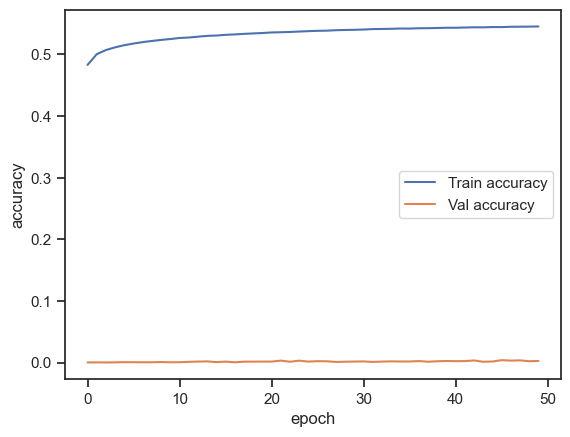

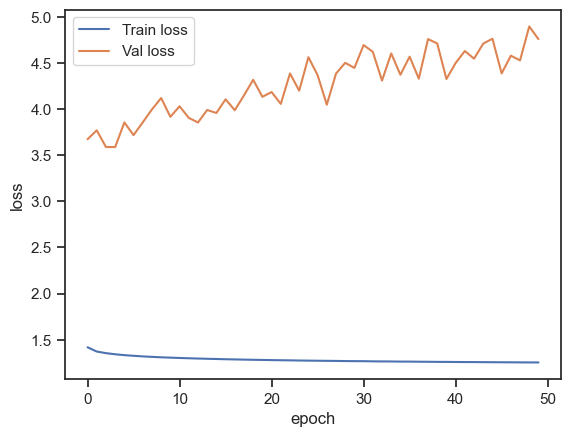

In [106]:
# Answer here
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="ticks")
sns.lineplot(x = training_log.epoch, y = training_log.accuracy, label='Train accuracy')
sns.lineplot(x = training_log.epoch, y = training_log.val_accuracy, label='Val accuracy')
plt.show()

sns.lineplot(x = training_log.epoch, y = training_log.loss, label='Train loss')
sns.lineplot(x = training_log.epoch, y = training_log.val_loss, label='Val loss')
plt.show()

In [107]:
#create a csv with result.csv
list_resid = df_test['id'].tolist()
Ser1_res = pd.Series(list_resid)
Ser2_res = pd.Series(pred_result)
df_res = pd.DataFrame({'id':Ser1_res, 'emotion':Ser2_res})
df_res.to_csv('result.csv', index=False)

In [108]:
#ensure inside result.csv
df_res.shape

(411972, 2)